In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.special import jv

In [254]:
'''
Geometrized constants, units of meters.
'''

c = 299792458                 # Speed of light: m/s
G = 6.6743e-11                # Gravitational Constant: m^3 / (kg s^2)
Msun = 2e30 * G / c**2        # Solar Masses: meters
M = 4e6 * Msun                # SMBH Mass: meters
parsec_to_m = 3e16            # meters per parsec
mstar = 0.05 * Msun           # CO Mass: meters
mu = (M * mstar) / (M + mstar)# reduced mass
D = 1e3*parsec_to_m*8
YEAR = 3600.0*24.0*365.0

In [5]:
# Peters' equations (da/dt, de/dt)
def dadt(a, e):
    """
    Rate of change of semi-major axis
    Geometrized units of meters and G = c = 1
    (Peters 1964)
    """
    return -(64/5) * mu * M**2 / (a**3 * (1 - e**2)**(3.5)) * (1 + (73/24)*e**2 + (37/96)*e**4)

def dedt(a, e):
    """
    Rate of change of eccentricity 
    Geometrized units of meters and G = c = 1
    (Peters 1964)
    """
    return -(304/15) * e * mu * M**2 / (a**4 * (1 - e**2)**(2.5)) * (1 + (121/204)*e**2)

def deriv(t,y):
    a, e = y
    da = dadt(a, e)
    de = dedt(a, e)
    return [da, de]

# Initial conditions
a0 = 2/1000 * parsec_to_m  # initial semi-major axis
e0 = 0.999                # initial eccentricity
y0 = [a0, e0]

In [342]:
tfinal = ((10**9 * 365 * 24 * 3600)*c) # Total time: meters

sol = solve_ivp(
    deriv, 
    t_span=(0, tfinal), 
    y0=y0, 
    rtol=1e-10, 
    atol=1e-12
)

t_arr = sol.t                              # Time array (meters)
a_arr, e_arr = sol.y                       # a_arr: semi-major axis (meters), e_arr: eccentricity (unitless)

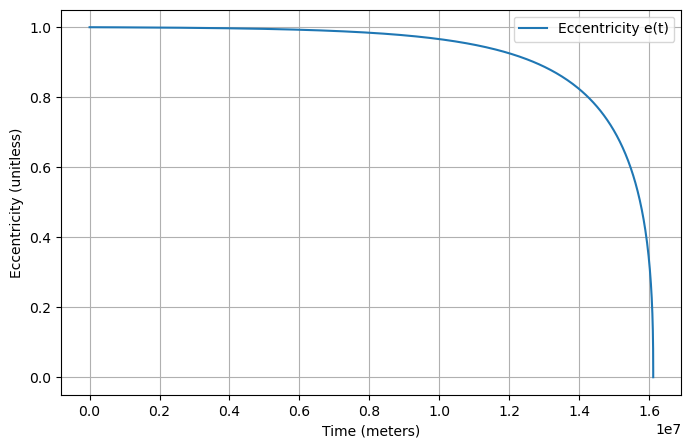

In [344]:
# Plot results
plt.figure(figsize=(8,5))
plt.plot(t_arr/(c*YEAR), e_arr, label='Eccentricity e(t)')
plt.xlabel('Time (meters)')
plt.ylabel('Eccentricity (unitless)')
plt.grid(True)
plt.legend()
plt.show()

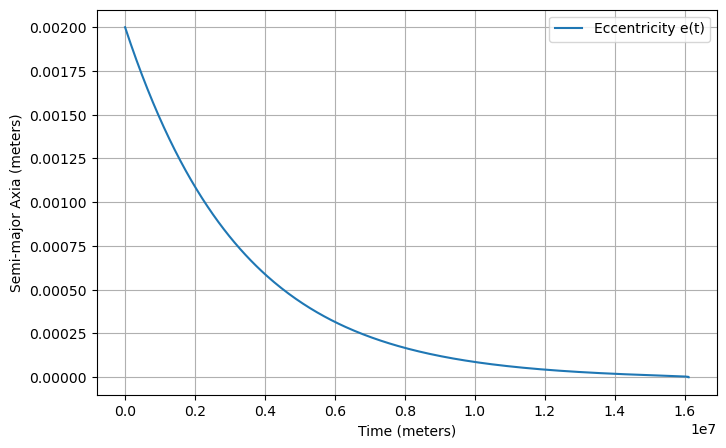

In [346]:
# Plot results
plt.figure(figsize=(8,5))
plt.plot(t_arr/(c*YEAR), a_arr/parsec_to_m, label='Eccentricity e(t)')
plt.xlabel('Time (meters)')
plt.ylabel('Semi-major Axia (meters)')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
'''
Defining the Characteristic Strain from the Detector using FEW Waveforms
'''

'\nDefining the Characteristic Strain from the Detector using FEW Waveforms\n'

In [15]:
from few.waveform import GenerateEMRIWaveform
from few.utils.constants import MTSUN_SI
from few.utils.utility import get_p_at_t
from few.utils.geodesic import get_fundamental_frequencies
from few.utils.fdutils import GetFDWaveformFromFD, GetFDWaveformFromTD
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode.flux import KerrEccEqFlux
from scipy.interpolate import CubicSpline
from few import get_file_manager
from scipy.integrate import cumulative_trapezoid


In [16]:
# produce sensitivity function
traj_module = EMRIInspiral(func=KerrEccEqFlux)

# import ASD
data = np.loadtxt(get_file_manager().get_file("LPA.txt"), skiprows=1)
frequencies = data[:,0]
psd_values  = data[:, 1] ** 2
# define PSD function
get_sensitivity = CubicSpline(frequencies, psd_values)

In [23]:
'''

'''
def h_det(f):
    return (get_sensitivity(f))

In [25]:
#S_FEW = h_det(f_plots)

In [27]:
def g_n_e(n, e):
    ne = n*e
    Jn_2 = jv(n-2, ne)
    Jn_1 = jv(n-1, ne)
    Jn   = jv(n,   ne)
    Jn1  = jv(n+1, ne)
    Jn2  = jv(n+2, ne)
    term1 = Jn_2 - 2*e*Jn_1 + (2.0/n)*Jn + 2*e*Jn1 - Jn2
    term2 = Jn_2 - 2*Jn + Jn2
    return (n**4/32.0) * (term1**2 + (1 - e**2)*term2**2 + (4.0/(3*n**2))*(Jn**2))


In [29]:
def h_n(n,e,a):
    return g_n_e(n, e)*M*mstar/(D*a)

In [501]:
def f_orb(a):
    '''
    Keplerian orbital frequency
    Returns in meters^-1
    '''
    return (1/(2*np.pi))*np.sqrt((M+mstar)/a**3)

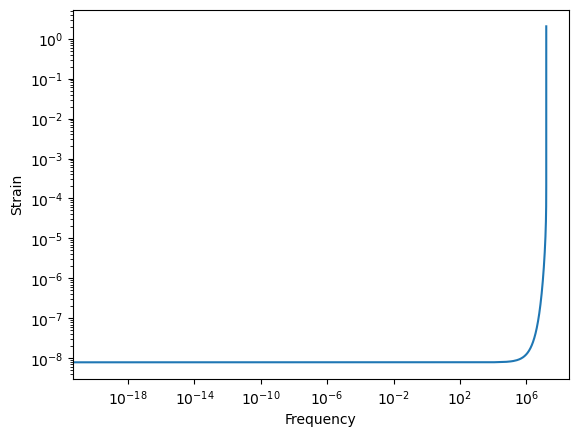

In [175]:
def plot_time_strain(a_arr, e_arr, n):
    # pick one harmonic (say n=2) for simplicity
    f = n * f_orb(a_arr)*c   # convert to Hz
    #h = h_n(n, e_arr,a_arr)
    plt.loglog((t_arr/c)/(3600.0*24*365), f, label=f'n={n}')
    plt.xlabel("Frequency")
    plt.ylabel("Strain")

# example usage
plot_time_strain(a_arr, e_arr, n=1)


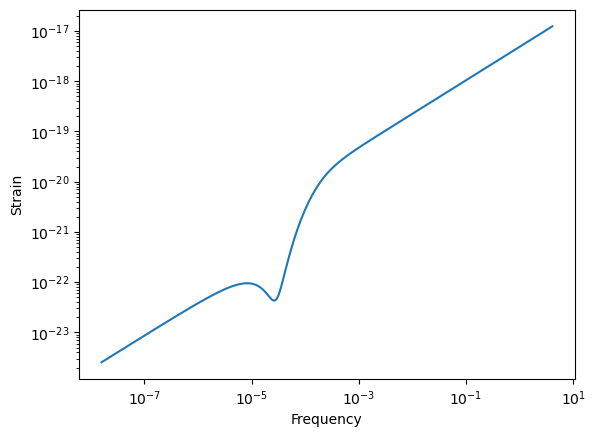

In [33]:
def plot_evolving_strain(a_arr, e_arr, n):
    # pick one harmonic (say n=2) for simplicity
    f = n * f_orb(a_arr)*c   # convert to Hz
    h = h_n(n, e_arr,a_arr)
    plt.loglog(f, h, label=f'n={n}')
    plt.xlabel("Frequency")
    plt.ylabel("Strain")

# example usage
plot_evolving_strain(a_arr, e_arr, n=2)


In [ ]:
plt.figure(figsize=(8,6))
n = 1
f = n * f_orb(a_arr)*c   # convert 1/s
# We convert back since the strain of the detector was originally calculated with non-geometrized units
plot_evolving_strain(a_arr, e_arr, n)
plt.loglog(f, np.sqrt(h_det(f)), 'k--', lw=2, label='LISA sensitivity (√Sₙ)')
plt.xlabel('Frequency [1/s]')
plt.ylabel('Strain amplitude $h_n$')
plt.title('Evolving X-MRI strain vs LISA sensitivity')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()

In [199]:
def integral(a, e, n,dt_i):
    #for n in range(1, n+1):
    f_Hz = n * f_orb(a) * c
    hn   = h_n(n, e, a)
    hdet = np.sqrt(h_det(f_Hz))  # ASD

    return (hn/hdet)**2 * (dt_i/c)

In [384]:
 def integrate_function(P, t_s):
        S = np.concatenate([[0.0], np.cumsum(P)])         # simple sum (since P already includes dt)
        # find index j such that t_s[j] - t_s[i] ~ 1 yr
        idx_end = np.searchsorted(t_s, t_s + YEAR, side='right') - 1
        idx_end = np.clip(idx_end, 0, len(P)-1)
        # integral from i to j is sum P[k] for k in [i, j]
        return S[idx_end+1] - S[:-1]

In [425]:
def snr_1yr_vs_time(a_arr, e_arr, t_arr, N_harm_show=10, N_harm_sum=1000):
    dt_arr = np.diff(t_arr, prepend=t_arr[0])
    T = len(t_arr)
    integral_value_show = np.zeros((N_harm_show, T))
    integral_value_total = np.zeros(T)

    # Calculating the integral at each time
    for i in range(T):
        a, e, dt_meters = a_arr[i], e_arr[i], dt_arr[i]
        
        for n in range(1, N_harm_show+1):
            integral_value_show[n-1, i] =  integral(a, e, n,dt_meters)
        s = 0.0
        for n in range(1, N_harm_sum+1):
            s += integral(a, e, n,dt_meters)
        integral_value_total[i] = s

    # Converting back to seconds
    dt_s = dt_arr / c                           # seconds
    t_s  = np.cumsum(dt_s)                       # seconds from start
    
    SNR2_total_1yr = integral_value_total#integrate_function(integral_value_total, t_s)
    SNR2_total_1yr_integrated = integrate_function(integral_value_total, t_s)
    SNR2_show_1yr  = np.vstack([integrate_function(integral_value_show[k], t_s) for k in range(N_harm_show)])

    # x-axis: time to plunge (years), reverse so it decreases to the right
    t_to_plunge_yr = (t_arr[-1] - t_arr) / c / YEAR

    return t_to_plunge_yr, np.sqrt(SNR2_total_1yr), np.sqrt(SNR2_show_1yr), np.sqrt(SNR2_total_1yr_integrated)

In [431]:
def plot_SNR(a_arr, e_arr, t_arr, N_harm_show=10, N_harm_sum=1000):
    time_to_plunge, SNR_tot, SNR_h, SNR_integrated = snr_1yr_vs_time(a_arr, e_arr, t_arr)

    plt.figure(figsize=(8,6))
    for i in range(SNR_h.shape[0]):
        plt.loglog(time_to_plunge, SNR_h[i], '--', lw=1)
    plt.loglog(time_to_plunge, SNR_tot, 'k', lw=2, label='Total SNR (sum up to n={1000})')
    plt.loglog(time_to_plunge, SNR_integrated, lw=2, color = 'green')
    plt.xlim(1e7, 1) 
    plt.xlabel('Time to plunge (yr)')
    plt.ylabel('SNR for 1-yr observation')
    plt.title('SNR for 1-yr observation vs Time to Plunge')
    plt.grid(True, which='both', ls=':')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

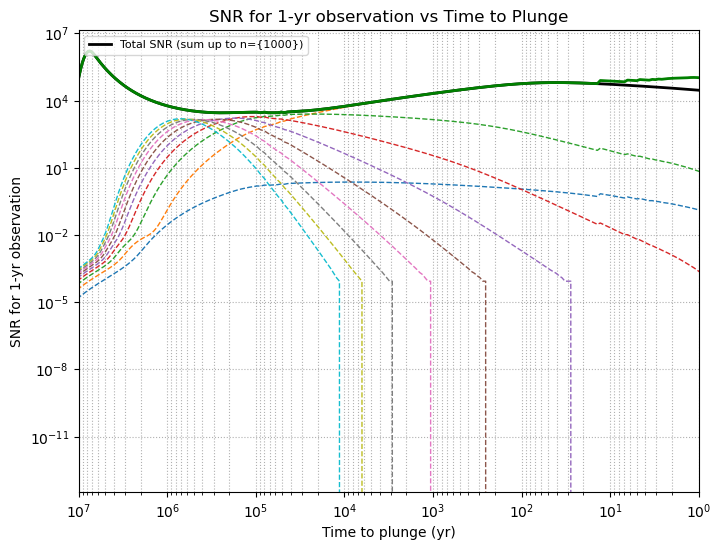

In [433]:
plot_SNR(a_arr, e_arr, t_arr)#, N_harm_show=10, N_harm_sum=1000)

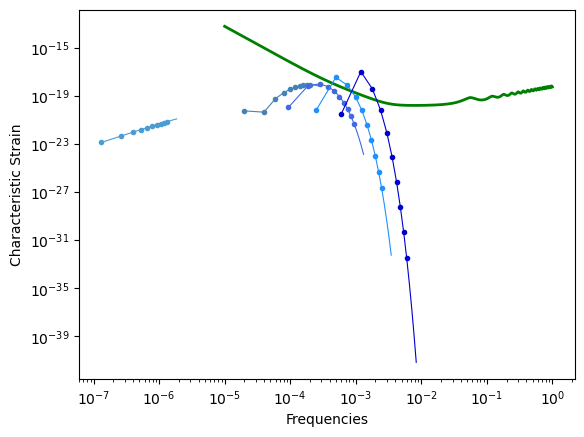

In [523]:
plt.loglog(frequencies, np.sqrt(h_det(frequencies)), lw=2, color = 'green')
colors = ['#4B9CD3', '#4682B4', '#4169E1', '#1E90FF', '#0000CD']

for j, (T, idx, color) in enumerate(zip(isochrones, idxs, colors)):
    e_iso = e_arr[idx]
    a_iso = a_arr[idx]
    f_orbital = f_orb(a_iso) * c  # Hz
    n_vals = np.arange(1, 15)
    f_n = n_vals * f_orbital
    h_n_vals = np.array([h_n(n, e_iso, a_iso) for n in range(1, 15)])
    #h_c_vals = h_n_vals * np.sqrt(f_n)   # characteristic strain
    h_c_vals = h_n_vals * np.sqrt(f_n * YEAR)
    
    plt.loglog(f_n, h_c_vals, lw=0.8, color=color)
    plt.plot(f_n[:10], h_c_vals[:10], 'o', color=color, markersize=3)
    
    # Annotate with Rp/Rs and e
    #R_s = 2 * G * M / c**2
    #Rp_Rs = a_iso * (1 - e_iso) / R_s
    #plt.text(f_n[10], h_c_vals[10]*1.2, f"{int(T):.0e} yr: e={e_iso:.3f}, Rp/Rs={Rp_Rs:.1f}", color=color, fontsize=7)

plt.xlabel('Frequencies')
plt.ylabel('Characteristic Strain')
plt.show()

In [447]:
isochrones = np.array([1e7, 1e6, 1e5, 1e4, 1e3])

In [453]:
time_to_plunge_yr = (t_arr[-1] - t_arr) / c / YEAR

In [455]:
idxs = [np.argmin(np.abs(time_to_plunge_yr - T)) for T in isochrones]

In [489]:
a_a = a_arr / YEAR

In [493]:
hn = h_n(1, e_arr[idxs], a_arr[idxs])
print(e_arr[idxs], a_arr[idxs])
print(hn)

[0.99154522 0.68352294 0.30820256 0.12730124 0.05155442] [9.18547659e+12 3.24541517e+11 1.15211211e+11 6.02766848e+10
 3.35554233e+10]
[6.63855647e-24 2.30297970e-22 2.07158826e-22 7.34125580e-23
 2.19325078e-23]


ValueError: x and y must have same first dimension, but have shapes (706,) and (1,)

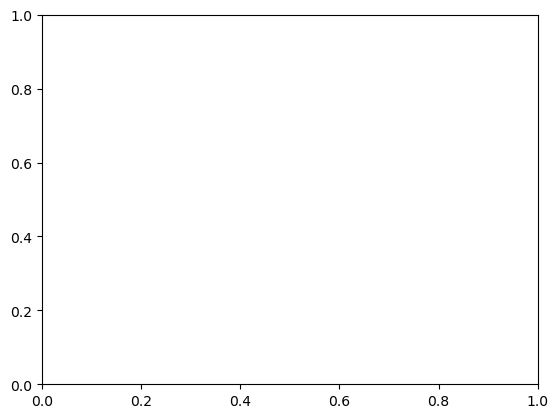

In [479]:
for n in range(1, 11):
    f = f_orb(a_arr)*c
    hn   = h_n(n, e_arr, a_arr)
    plt.plot(f, h_n)

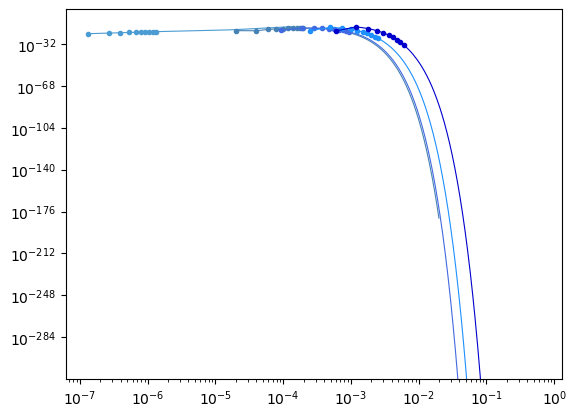

In [521]:
colors = ['#4B9CD3', '#4682B4', '#4169E1', '#1E90FF', '#0000CD']

for j, (T, idx, color) in enumerate(zip(isochrones, idxs, colors)):
    e_iso = e_arr[idx]
    a_iso = a_arr[idx]
    f_orbital = f_orb(a_iso) * c  # Hz
    n_vals = np.arange(1, 1001)
    f_n = n_vals * f_orbital
    h_n_vals = np.array([h_n(n, e_iso, a_iso) for n in n_vals])
    #h_c_vals = h_n_vals * np.sqrt(f_n)   # characteristic strain
    h_c_vals = h_n_vals * np.sqrt(f_n * YEAR)

    plt.loglog(f_n, h_c_vals, lw=0.8, color=color)
    plt.plot(f_n[:10], h_c_vals[:10], 'o', color=color, markersize=3)
    
    # Annotate with Rp/Rs and e
    #R_s = 2 * G * M / c**2
    #Rp_Rs = a_iso * (1 - e_iso) / R_s
    #plt.text(f_n[10], h_c_vals[10]*1.2, f"{int(T):.0e} yr: e={e_iso:.3f}, Rp/Rs={Rp_Rs:.1f}", color=color, fontsize=7)
